In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

os.chdir('..')

In [3]:
import pickle
import itertools
import glob

import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

import configs
from utils import utils
from utils import laion_utils as laionu
from utils import wordnet_utils as wnu
from utils.calc_utils import calc_recall_per_y, calc_equi_acc, combine_recalls, z
from core.ilsvrc_predictors import all_model_names_1k, all_model_names_pt21k_ft1k, all_model_names_21k
from core.queries import QueryType

[nltk_data] Downloading package wordnet to /Users/alishri/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/Users/alishri/Desktop/Berkeley/research/hardt/projects/why imagenet looks unlike laion/codes/eval-on-laion/laionvenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Settings

## Filtering

In [4]:
q_type = QueryType.NAME_DEF
q_key = 'wnid'
text_encoder_ver = configs.CLIPConfig.DEFAULT_VERSION  # or 'all-mpnet-base-v2'

query_col = q_type + '_' + q_key
text_query_sim_col = f'text_to_{query_col}_similarity_{text_encoder_ver}'

rec_text_is_in_col = f'wnid_is_in_recognized_text'

print(text_query_sim_col)

text_to_name_def_wnid_similarity_clip-vit-base-patch32


## Path

### LAIONet

In [5]:
laion_path = 'laion400m'
laion_until_part = 31

laionet_prefix = configs.NamingConfig.append_filtered(configs.NamingConfig.SUBSET_SM_PREFIX, text_query_sim_col)

do_skim = False  # Skimmed version of LAIONet only keeps top 50 matches for each class
if do_skim:
    laionet_prefix = configs.NamingConfig.append_skimmed(laionet_prefix)

laionet_file_name = laionet_prefix + '_' + laionu.get_laion_subset_file_name(0, laion_until_part)

print(laionet_file_name)

# Labels
laionet_labels_path = os.path.join(laion_path, 'processed', 'ilsvrc_labels')
laionet_labels_file_name = f'wnid2laionindices({laionet_prefix}).pkl'

subset_sm_filt(text_to_name_def_wnid_similarity_clip-vit-base-patch32)_part-00000-to-part00031-5b54c5d5-bbcf-484d-a2ce-0d6f73df1a36-c000.snappy.parquet


### ImageNet-V2

In [6]:
iv2_path = 'imagenetv2'

iv2_prefixes = ['top-images', 'threshold0.7', 'matched-frequency']

iv2_file_names = ['imagenetv2-' + p + '.parquet' for p in iv2_prefixes]

iv2prefix2ver = {'top-images': 'c', 'threshold0.7': 'a', 'matched-frequency': 'b'}

# Labels
iv2_labels_file_paths = [
    os.path.join(iv2_path, 'processed', 'labels', f'imagenetv2-{p}-imagename2wnid.pkl')
    for p in iv2_prefixes
]

## Other

In [7]:
top_k_col = lambda k, mdl: f'top_{k}_is_correct_{mdl}'

iv2prefix2color = {
    'top-images': 'r',
    'threshold0.7': 'y',
    'matched-frequency': 'g',
}

## Models

In [8]:
model_names = all_model_names_1k + all_model_names_pt21k_ft1k + all_model_names_21k

print('\n'.join(model_names))

resnet-18
resnet-34
resnet-50
resnet-101
resnet-152
convnext-tiny-224
convnext-small-224
convnext-base-224
convnext-large-224
convnext-base-384
convnext-large-384
vit-base-patch16-224
vit-base-patch16-384
vit-base-patch32-384
vit-large-patch16-224
vit-large-patch16-384
vit-large-patch32-384
convnext-base-224-22k-1k
convnext-large-224-22k-1k
convnext-base-384-22k-1k
convnext-large-384-22k-1k
beit-base-patch16-224
beit-base-patch16-384
beit-large-patch16-224
beit-large-patch16-384
convnext-base-224-22k
convnext-large-224-22k
beit-base-patch16-224-pt22k-ft22k
beit-large-patch16-224-pt22k-ft22k


# Load

## LAIONet

In [9]:
df = pd.read_parquet(
    os.path.join(laion_path, laionet_file_name)
)

df.head(3)

,SAMPLE_ID,URL,TEXT,HEIGHT,WIDTH,LICENSE,NSFW,similarity,name_def_wnid,text_to_name_def_wnid_similarity_clip-vit-base-patch32,...,top_5_is_correct_convnext-large-384,top_1_is_correct_convnext-base-224-22k-1k,top_5_is_correct_convnext-base-224-22k-1k,top_1_is_correct_convnext-large-224-22k-1k,top_5_is_correct_convnext-large-224-22k-1k,top_1_is_correct_convnext-base-384-22k-1k,top_5_is_correct_convnext-base-384-22k-1k,top_1_is_correct_convnext-large-384-22k-1k,top_5_is_correct_convnext-large-384-22k-1k,wnid_is_in_recognized_text
69,1.127880e+12,http://images4-b.ravelrycache.com/uploads/Wool...,Oval_drum_small2,320.0,320.0,?,UNLIKELY,0.306868,drum which is a musical percussion instrument;...,0.853099,...,True,True,True,True,True,True,True,True,True,False
2176,3.572065e+12,https://i0.wp.com/www.paginascanarias.com/wp-c...,barbershop triana,200.0,200.0,?,UNLIKELY,0.318373,barbershop which is a shop where men can get t...,0.827356,...,True,False,True,False,True,False,True,False,True,False
3188,2.178581e+12,http://static11.zobazo.com/USA/2018//2694/4320...,Four marmoset monkey available for sale (male ...,160.0,135.0,?,UNLIKELY,0.358621,marmoset which is small soft-furred South Amer...,0.824072,...,None,None,None,None,None,None,None,None,None,False


## ImageNet-V2

In [10]:
iv2prefix2df = {}
for cnt, file_name in enumerate(iv2_file_names):
    iv2prefix2df[iv2_prefixes[cnt]] = pd.read_parquet(os.path.join(iv2_path, file_name))

    print(iv2prefix2df[iv2_prefixes[cnt]].shape)

iv2prefix2df[iv2_prefixes[0]].head(3)

(10000, 58)
(10000, 58)
(10000, 58)


,top_1_is_correct_resnet-18,top_5_is_correct_resnet-18,top_1_is_correct_resnet-34,top_5_is_correct_resnet-34,top_1_is_correct_resnet-50,top_5_is_correct_resnet-50,top_1_is_correct_resnet-101,top_5_is_correct_resnet-101,top_1_is_correct_resnet-152,top_5_is_correct_resnet-152,...,top_1_is_correct_convnext-large-384,top_5_is_correct_convnext-large-384,top_1_is_correct_convnext-base-224-22k-1k,top_5_is_correct_convnext-base-224-22k-1k,top_1_is_correct_convnext-large-224-22k-1k,top_5_is_correct_convnext-large-224-22k-1k,top_1_is_correct_convnext-base-384-22k-1k,top_5_is_correct_convnext-base-384-22k-1k,top_1_is_correct_convnext-large-384-22k-1k,top_5_is_correct_convnext-large-384-22k-1k
0/bcf8a5326180b5e9320642f5024096fbc8a5d454.jpeg,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
0/83f4031ff33228b81c998261cd7139e62901d0ec.jpeg,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
0/0af3f1b55de791c4144e2fb6d7dfe96dfc22d3fc.jpeg,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


## Labels

In [11]:
with open(os.path.join(laionet_labels_path, laionet_labels_file_name), 'rb') as f:
    wnid2laionindices = pickle.load(f)

In [12]:
iv2prefix2wnid2imagenames = {}

for cnt, file_path in enumerate(iv2_labels_file_paths):
    with open(file_path, 'rb') as f:
        imagename2wnid = pickle.load(f)
    
    # Find the inverse map
    iv2prefix2wnid2imagenames[iv2_prefixes[cnt]] = utils.find_inverse_map(imagename2wnid)

# Calc. recall and accuracy

In [13]:
if text_encoder_ver == configs.CLIPConfig.DEFAULT_VERSION:
    tq_sim_th = 0.82
elif text_encoder_ver == 'all-mpnet-base-v2':
    tq_sim_th = 0.58
else:
    raise Exception('We have not yet published a LAIONet for other encoders.')

## LAIONet

In [14]:
df_filt = df[df[text_query_sim_col] >= tq_sim_th]

topk2model2wnid2recall = {1: {}, 5: {}}
topk2model2wnid2recallse = {1: {}, 5: {}}
topk2model2acc = {1: {}, 5: {}}
topk2model2nwnid = {1: {}, 5: {}}


for k in [1, 5]:
    topk2model2wnid2recall[k], topk2model2wnid2recallse[k], _ = \
        calc_recall_per_y(df_filt, wnid2laionindices, model_names, k, drop_if_true_cols=[rec_text_is_in_col])
    
    topk2model2acc[k], topk2model2nwnid[k] = \
        calc_equi_acc(model_names, topk2model2wnid2recall[k], topk2model2wnid2recallse[k])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 978/978 [04:13<00:00,  3.86it/s]


## ImageNet-V2

In [15]:
projected_iv2prefix2wnid2imagenames = {}

for prefix in iv2_prefixes:
    projected_iv2prefix2wnid2imagenames[prefix] = {
        wnid: image_names 
        for wnid, image_names in iv2prefix2wnid2imagenames[prefix].items()
        if wnid in wnid2laionindices
    }

In [16]:
iv2prefix2topk2model2wnid2recall = {p: {1: {}, 5: {}} for p in iv2_prefixes}
iv2prefix2topk2model2wnid2recallse = {p: {1: {}, 5: {}} for p in iv2_prefixes}
iv2prefix2topk2model2acc = {p: {1: {}, 5: {}} for p in iv2_prefixes}

for p in iv2_prefixes:
    for k in [1, 5]:
        iv2prefix2topk2model2wnid2recall[p][k], iv2prefix2topk2model2wnid2recallse[p][k], _ = \
            calc_recall_per_y(iv2prefix2df[p], projected_iv2prefix2wnid2imagenames[p], model_names, k)

        iv2prefix2topk2model2acc[p][k], _ = \
            calc_equi_acc(model_names, iv2prefix2topk2model2wnid2recall[p][k], iv2prefix2topk2model2wnid2recallse[p][k])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 977/977 [00:05<00:00, 162.88it/s]


# Plot accuracy

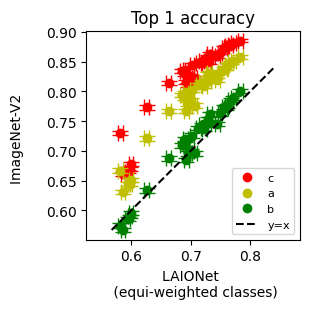

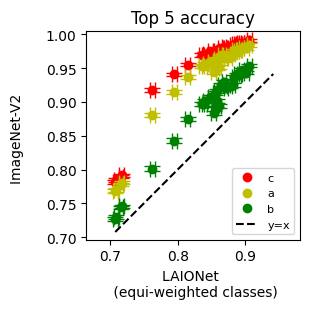

In [17]:
for top_k in [1, 5]:

    plt.figure(figsize=(3.2, 3.2))

    min_acc, max_acc = np.inf, -np.inf
    
    laionet_accs = [topk2model2acc[top_k][m]['acc'] for m in model_names]
    laionet_acc_ses = [topk2model2acc[top_k][m]['acc_se'] for m in model_names]
    
    min_acc = np.minimum(min_acc, np.min(laionet_accs))
    max_acc = np.maximum(max_acc, np.max(laionet_accs))
        
    iv2prefix2handle = {}
    for p in iv2_prefixes:
        cl = iv2prefix2color[p]
        
        iv2_accs = [iv2prefix2topk2model2acc[p][top_k][m]['acc'] for m in model_names]
        iv2_acc_ses = [iv2prefix2topk2model2acc[p][top_k][m]['acc_se'] for m in model_names]
        
        min_acc = np.minimum(min_acc, np.min(iv2_accs))
        max_acc = np.maximum(max_acc, np.max(iv2_accs))
        
        h = plt.plot(laionet_accs, iv2_accs, 'o', color=cl)
        plt.errorbar(
            laionet_accs, 
            iv2_accs,
            xerr=np.array(laionet_acc_ses)*z, 
            yerr=iv2_acc_ses,
            capsize=6,
            color=cl,
            linestyle='none'
        )
        
        iv2prefix2handle[p] = h[0]


    h = plt.plot([min_acc, max_acc*0.95], [min_acc, max_acc*0.95], 'k--')

    plt.legend(
        handles=[iv2prefix2handle[p] for p in iv2_prefixes] + [h[0]],
        labels=[iv2prefix2ver[p] for p in iv2_prefixes] + ['y=x'],
        loc='lower right',
        fontsize=8
    )

    plt.title(f'Top {top_k} accuracy')
    plt.xlabel('LAIONet \n (equi-weighted classes)')
    plt.ylabel('ImageNet-V2 \n')

    plt.axis('equal')

    plt.tight_layout()

    plt.savefig(os.path.join('figs', 'top%d_equi-acc_vs_imagenetv2-acc_%s(tqsim%.2f).pdf' % (top_k, laionet_prefix, tq_sim_th)), bbox_inches='tight')
    